# Church analytics

Third Analysis add-on from Python notebook and Power BI dashboard

- KPI's Analysis
- Givers Analysis
- Month Analysis
- Comments with Relationship Analysis

In [118]:
%load_ext sql


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [119]:
%sql sqlite:///Church.db


In [120]:
import csv
import pandas as pd
import pandas
import matplotlib.pyplot as plt
import sqlite3


conn = sqlite3.connect("Church.db")
cur = conn.cursor()

df = pandas.read_csv('ejemplo.csv')
df.to_sql("church", conn, if_exists='replace', index=False, method="multi", chunksize=300)


print("SQLite database created successfully.")



SQLite database created successfully.


In [121]:
%sql SELECT name FROM sqlite_master WHERE type='table'

 * sqlite:///Church.db
Done.


name
church


### KPI's

In [122]:
%%sql
SELECT SUM(Amount) AS Total_Donations FROM church

 * sqlite:///Church.db
Done.


Total_Donations
10286


In [123]:
%%sql
SELECT AVG(Amount) AS Average_Donation
FROM church

 * sqlite:///Church.db
Done.


Average_Donation
109.42553191489361


Donations Type analysis

In [124]:
%%sql
SELECT Type, 
       SUM(Amount) AS Total_Donations,
       COUNT(*) AS Donation_Count,
       AVG(Amount) AS Average_Donation
FROM church
GROUP BY Type
ORDER BY Average_Donation DESC

 * sqlite:///Church.db
Done.


Type,Total_Donations,Donation_Count,Average_Donation
Local_Church_Budget,1340,11,121.81818181818181
Tithe,7540,65,116.0
Local_Church_Building,1406,18,78.11111111111111


AVG of Tithes: we saw it is 116€, lets recheck it

In [125]:
%%sql
SELECT 
    'Tithe' AS Donation_Type,
    AVG(Amount) AS Avg_Tithe_Amount
FROM 
    church
WHERE 
    Type = 'Tithe'


 * sqlite:///Church.db
Done.


Donation_Type,Avg_Tithe_Amount
Tithe,116.0


AVG of net People salary based on the 10% tithe rule

In [126]:
%%sql
-- Average tithe amount
WITH Average_Tithe AS (
    SELECT AVG(Amount) AS Avg_Tithe
    FROM church
    WHERE Type = 'Tithe'
),

-- Estimated average net salary
Estimated_Average_Salary AS (
    SELECT Avg_Tithe / 0.1 AS Estimated_Avg_Salary
    FROM Average_Tithe
)

SELECT Estimated_Avg_Salary
FROM Estimated_Average_Salary

 * sqlite:///Church.db
Done.


Estimated_Avg_Salary
1160.0


Lets see if people with Higher Salaries give more than Tithes to the church or if people with Lower Salaries do

In [127]:
%%sql

-- Estimate Net Salary
WITH Estimated_Net_Salary AS (
    SELECT 
        Name,
        SUM(Amount) / 0.1 AS Estimated_Net_Salary
    FROM 
        church
    WHERE 
        Type = 'Tithe'
    GROUP BY 
        Name
),

-- Categorizing people based on AVG Salary
Salary_Categories AS (
    SELECT 
        Name,
        Estimated_Net_Salary,
        CASE 
            WHEN Estimated_Net_Salary >= (SELECT AVG(Estimated_Net_Salary) FROM Estimated_Net_Salary) THEN 'Higher Salary'
            ELSE 'Lower Salary'
        END AS Salary_Category
    FROM 
        Estimated_Net_Salary
),

-- Total Donations to other causes
Total_Donations_Other_Causes AS (
    SELECT 
        sc.Salary_Category,
        COALESCE(SUM(c.Amount), 0) AS Total_Offerings_EUR
    FROM 
        Salary_Categories sc
    LEFT JOIN 
        church c ON sc.Name = c.Name AND c.Type <> 'Tithe'
    GROUP BY 
        sc.Salary_Category
)


SELECT 
    Salary_Category,
    Total_Offerings_EUR
FROM 
    Total_Donations_Other_Causes



 * sqlite:///Church.db
Done.


Salary_Category,Total_Offerings_EUR
Higher Salary,545
Lower Salary,145


People with Higher Salaries tend to give more than Tithes. Praise God!

### Donators Analysis

### Lets find out the

- Most_Giver_Amount: The person with the greatest SUM of donation given

- Most_Giver_Count: The person that is the most constant

- Most_Diverse_Donator: the person that spreads its donation the most

All of them ordered by the Type of donation

In [128]:
%%sql
WITH Total_Donations_Per_Person AS (
    SELECT Type, 
           Name, 
           SUM(Amount) AS Total_Amount,
           COUNT(*) AS Donation_Count
    FROM church
    GROUP BY Type, Name
),

Ranked_By_Amount AS (
    SELECT Type, 
           Name, 
           Total_Amount,
           ROW_NUMBER() OVER (PARTITION BY Type ORDER BY Total_Amount DESC) AS Amount_Rank
    FROM Total_Donations_Per_Person
),

Ranked_By_Count AS (
    SELECT Type, 
           Name, 
           Donation_Count,
           ROW_NUMBER() OVER (PARTITION BY Type ORDER BY Donation_Count DESC) AS Count_Rank
    FROM Total_Donations_Per_Person
),

Donation_Types_Per_Person AS (
    SELECT Name, 
           COUNT(DISTINCT Type) AS Types_Count
    FROM church
    GROUP BY Name
),

Most_Diverse_Donator AS (
    SELECT Name AS Most_Diverse_Donator, 
           Types_Count,
           ROW_NUMBER() OVER (ORDER BY Types_Count DESC) AS Diversity_Rank
    FROM Donation_Types_Per_Person
)

SELECT 
    a.Type,
    a.Name AS Most_Giver_Amount,
    a.Total_Amount AS Max_Total_Amount,
    c.Name AS Most_Giver_Count,
    c.Donation_Count AS Max_Donation_Count,
    d.Most_Diverse_Donator,
    d.Types_Count AS Diversity_Count
FROM 
    Ranked_By_Amount a
LEFT JOIN 
    Ranked_By_Count c ON a.Type = c.Type AND c.Count_Rank = 1
LEFT JOIN 
    Most_Diverse_Donator d ON d.Diversity_Rank = 1
WHERE 
    a.Amount_Rank = 1
ORDER BY 
    a.Type


 * sqlite:///Church.db
Done.


Type,Most_Giver_Amount,Max_Total_Amount,Most_Giver_Count,Max_Donation_Count,Most_Diverse_Donator,Diversity_Count
Local_Church_Budget,LIAM WILLIAMS,500,ELLIE COLE,1,LIAM WILLIAMS,3
Local_Church_Building,JACKSON FLORES,500,AIDEN BUTLER,1,LIAM WILLIAMS,3
Tithe,BENJAMIN MARTIN,250,AIDEN MILES,1,LIAM WILLIAMS,3


### Donators % contributions by Type

In [130]:
%%sql
SELECT Name, 
       SUM(Amount) AS Total_Donated, 
       SUM(CASE WHEN Type = 'Tithe' THEN Amount ELSE 0 END) AS Tithe_Amount,
       SUM(CASE WHEN Type = 'Local_Church_Budget' THEN Amount ELSE 0 END) AS Local_Church_Budget_Amount,
       SUM(CASE WHEN Type = 'Local_Church_Building' THEN Amount ELSE 0 END) AS Local_Church_Building_Amount,
       SUM(CASE WHEN Type NOT IN ('Tithe', 'Local_Church_Budget', 'Local_Church_Building') THEN Amount ELSE 0 END) AS Other_Amount,
       (SUM(Amount) * 100.0 / (SELECT SUM(Amount) FROM church)) AS Contribution_Percentage
FROM church
GROUP BY Name
ORDER BY Total_Donated DESC

 * sqlite:///Church.db
Done.


Name,Total_Donated,Tithe_Amount,Local_Church_Budget_Amount,Local_Church_Building_Amount,Other_Amount,Contribution_Percentage
LIAM WILLIAMS,795,250,500,45,0,7.72895197355629
JACKSON FLORES,500,0,0,500,0,4.860976083997667
JACKSON SANDERS,450,0,0,450,0,4.3748784755979
MASON FOSTER,250,0,250,0,0,2.4304880419988333
BENJAMIN MARTIN,250,250,0,0,0,2.4304880419988333
LOGAN GREEN,200,200,0,0,0,1.9443904335990667
LIAM BELL,200,200,0,0,0,1.9443904335990667
EMMA JONES,200,0,200,0,0,1.9443904335990667
AUBREY WOODS,200,200,0,0,0,1.9443904335990667
AUBREY GRIFFIN,200,200,0,0,0,1.9443904335990667


Is Liam Williams a High Salary person?

In [142]:
%%sql
-- Average Estimated Net Salary
WITH Estimated_Net_Salary AS (
    SELECT 
        Name,
        SUM(Amount) / 0.1 AS Estimated_Net_Salary
    FROM 
        church
    WHERE 
        Type = 'Tithe'
    GROUP BY 
        Name
),

Average_Net_Salary AS (
    SELECT 
        AVG(Estimated_Net_Salary) AS Avg_Net_Salary
    FROM 
        Estimated_Net_Salary
)

-- Checking if LIAM WILLIAMS is a High Salary person
SELECT 
    Name,
    Estimated_Net_Salary,
    CASE 
        WHEN Estimated_Net_Salary >= (SELECT Avg_Net_Salary FROM Average_Net_Salary) THEN 'High Salary'
        ELSE 'Low Salary'
    END AS Salary_Category
FROM 
    Estimated_Net_Salary
WHERE 
    Name = 'LIAM WILLIAMS';


 * sqlite:///Church.db
Done.


Name,Estimated_Net_Salary,Salary_Category
LIAM WILLIAMS,2500.0,High Salary


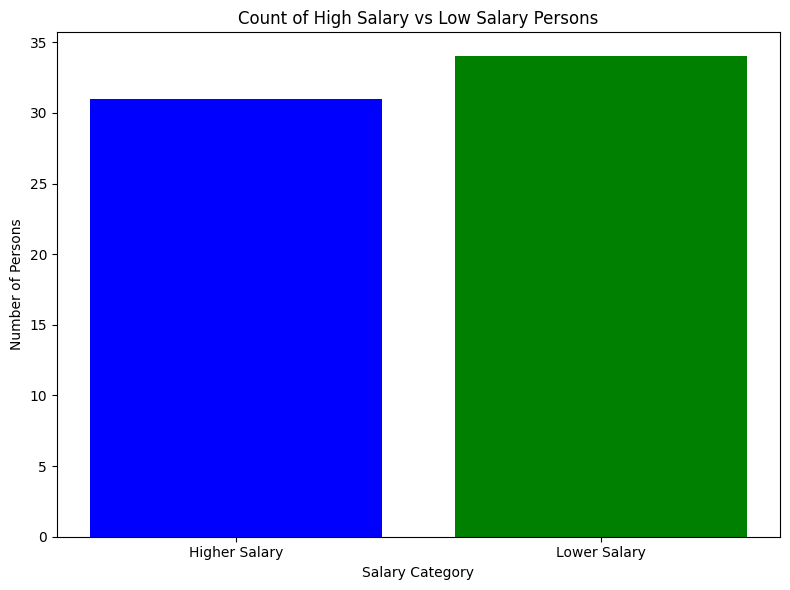

In [158]:
salary_vs = """
    -- Estimated Net Salary
    WITH Estimated_Net_Salary AS (
        SELECT 
            Name,
            SUM(Amount) AS Total_Tithe_Amount,
            SUM(Amount) / 0.1 AS Estimated_Net_Salary  -- Assuming 0.1 as the multiplier, adjust as needed
        FROM 
            church
        WHERE 
            Type = 'Tithe'
        GROUP BY 
            Name
    ),
    
    -- Categorize Salary
    Salary_Categories AS (
        SELECT 
            Name,
            Estimated_Net_Salary,
            CASE 
                WHEN Estimated_Net_Salary >= (
                    SELECT AVG(Estimated_Net_Salary) 
                    FROM Estimated_Net_Salary
                ) THEN 'Higher Salary'
                ELSE 'Lower Salary'
            END AS Salary_Category
        FROM 
            Estimated_Net_Salary
    )
    
    -- Count Persons in Each Salary Category
    SELECT 
        Salary_Category,
        COUNT(*) AS Person_Count
    FROM 
        Salary_Categories
    GROUP BY 
        Salary_Category;
"""

# Execute the query and fetch the results into a DataFrame
df = pd.read_sql_query(salary_vs, conn)

# Plotting the data
plt.figure(figsize=(8, 6))
plt.bar(df['Salary_Category'], df['Person_Count'], color=['blue', 'green'])
plt.xlabel('Salary Category')
plt.ylabel('Number of Persons')
plt.title('Count of High Salary vs Low Salary Persons')
plt.grid(False)
plt.tight_layout()
plt.show()


### People with full time job

In [131]:
%%sql
SELECT Name, SUM(Amount) AS Total_Donated
FROM church
WHERE Type = 'Tithe'
GROUP BY Name
HAVING Total_Donated > 40

 * sqlite:///Church.db
Done.


Name,Total_Donated
AIDEN MILES,80
AIDEN PHILLIPS,125
AIDEN WALKER,95
ANDREA SMITH,50
ARIA HENDERSON,85
ARIA JIMENEZ,125
ARIA TURNER,95
AUBREY EDWARDS,85
AUBREY GRIFFIN,200
AUBREY WOODS,200


In [132]:
%%sql
SELECT COUNT(DISTINCT Name) AS Donor_Count
FROM church
WHERE Amount > 40 AND Type = 'Tithe'

 * sqlite:///Church.db
Done.


Donor_Count
60


### People with part time jobs

In [155]:
%%sql
SELECT Name, SUM(Amount) AS Total_Donated
FROM church
WHERE Type = 'Tithe'
GROUP BY Name
HAVING Total_Donated < 40



 * sqlite:///Church.db
Done.


Name,Total_Donated
AMELIA ROBINSON,26
OLIVER CARTER,19
SCARLETT JACKSON,30
SEBASTIAN WHITE,20
ZOE KING,35


In [134]:
%%sql
SELECT COUNT(DISTINCT Name) AS Donor_Count
FROM church
WHERE Amount < 40 AND Type = 'Tithe'

 * sqlite:///Church.db
Done.


Donor_Count
5


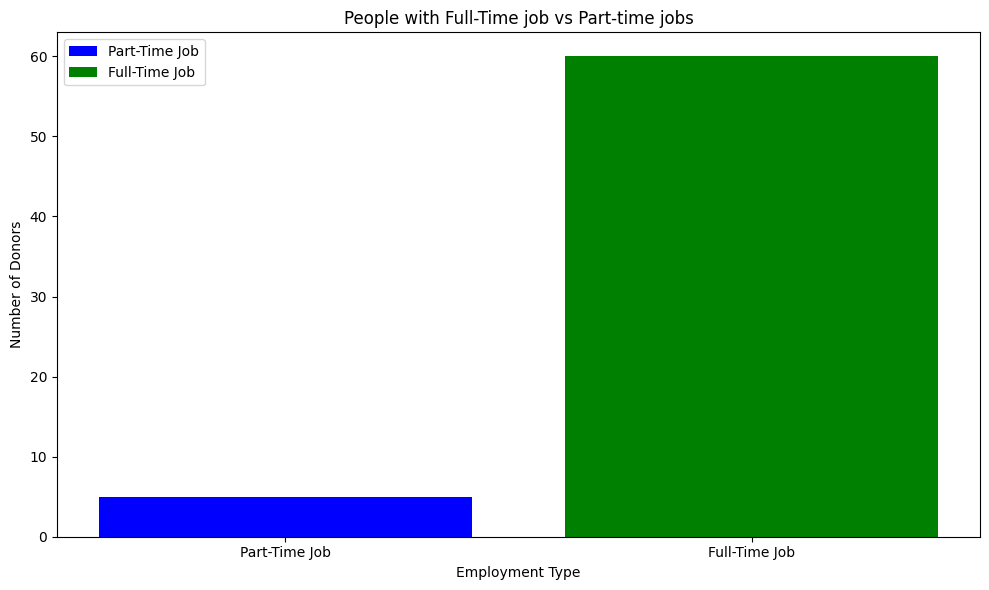

In [157]:

from IPython.display import display


# Defining SQL queries
query_full_time = """
    SELECT COUNT(DISTINCT Name) AS Donor_Count
    FROM church
    WHERE Amount > 40 AND Type = 'Tithe';
"""

query_part_time = """
    SELECT COUNT(DISTINCT Name) AS Donor_Count
    FROM church
    WHERE Amount < 40 AND Type = 'Tithe';
"""

# Executing queries
df_part_time = pd.read_sql_query(query_part_time, conn)
df_full_time = pd.read_sql_query(query_full_time, conn)

# Plotting the data
plt.figure(figsize=(10, 6))

# Plotting part-time job people (Amount > 40)
plt.bar('Part-Time Job', df_part_time['Donor_Count'], color='blue', label='Part-Time Job')

# Plotting full-time job people (Amount < 40)
plt.bar('Full-Time Job', df_full_time['Donor_Count'], color='green', label='Full-Time Job')

# Adding labels and title
plt.xlabel('Employment Type')
plt.ylabel('Number of Donors')
plt.title('People with Full-Time job vs Part-time jobs')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


There are more people with Full-Time jobs

But with lower Salaries

### Month Analysis

In [135]:
%%sql
SELECT strftime('%Y-%m', Date) AS Month, SUM(Amount) AS Total_Donations
FROM church
GROUP BY Month
ORDER BY Month

 * sqlite:///Church.db
Done.


Month,Total_Donations
2024-06,3522
2024-07,4312
2024-08,2452


### Top type of donation by month

In [136]:
top_type_by_month = """
WITH MonthlyTotals AS (
    SELECT strftime('%Y-%m', Date) AS Month, 
           Type, 
           SUM(Amount) AS Total_Donations
    FROM church
    GROUP BY Month, Type
),
RankedTotals AS (
    SELECT Month, 
           Type, 
           Total_Donations,
           ROW_NUMBER() OVER (PARTITION BY Month ORDER BY Total_Donations DESC) AS Rank
    FROM MonthlyTotals
)
SELECT Month, Type, Total_Donations
FROM RankedTotals
WHERE Rank = 1
ORDER BY Month;
"""

# Execute the query and load the result into a DataFrame
highest_type_df = pd.read_sql_query(top_type_by_month, conn)


# Display the DataFrame
highest_type_df

,Month,Type,Total_Donations
0,2024-06,Tithe,2840
1,2024-07,Tithe,2925
2,2024-08,Tithe,1775


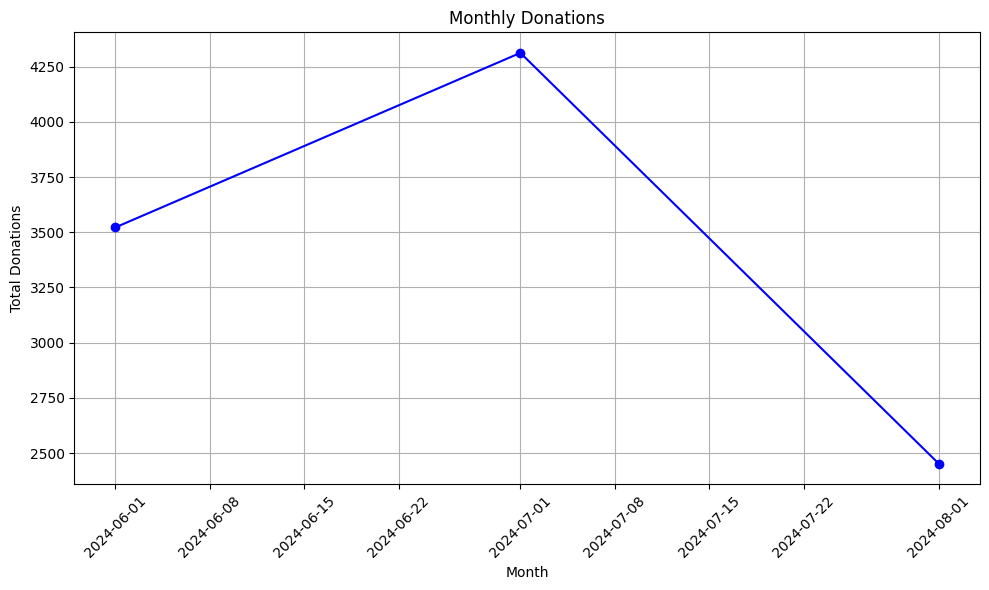

In [137]:
monthly_query = """
SELECT strftime('%Y-%m', Date) AS Month, SUM(Amount) AS Total_Donations
FROM church
GROUP BY Month
ORDER BY Month;
"""
monthly_df = pd.read_sql_query(monthly_query, conn)


# Convert 'Month' column to datetime
monthly_df['Month'] = pd.to_datetime(monthly_df['Month'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_df['Month'], monthly_df['Total_Donations'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Monthly Donations')
plt.xlabel('Month')
plt.ylabel('Total Donations')
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Total daily donations in july

Which time of the month we have more donations, looking at the month with the most donations; July

COUNT

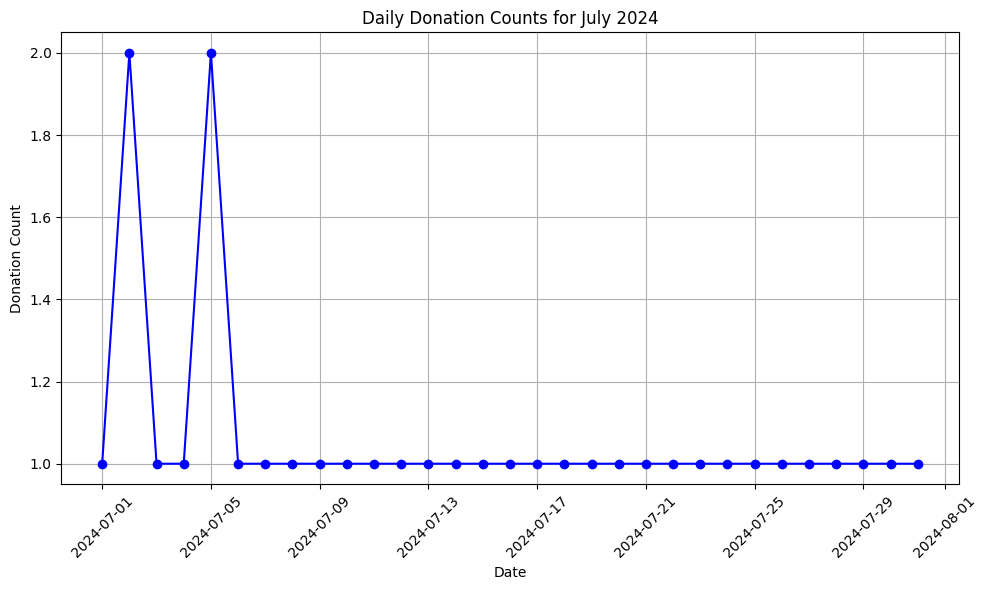

In [138]:
july_count_query = """
SELECT Date, COUNT(*) AS Donation_Count
FROM church
WHERE strftime('%Y-%m', Date) = '2024-07'
GROUP BY Date
ORDER BY Date;
"""

# Execute the query and load the data into a DataFrame
july_donations_count = pd.read_sql_query(july_count_query, conn)

# Convert 'Date' column to datetime
july_donations_count['Date'] = pd.to_datetime(july_donations_count['Date'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(july_donations_count['Date'], july_donations_count['Donation_Count'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Daily Donation Counts for July 2024')
plt.xlabel('Date')
plt.ylabel('Donation Count')
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

People seem to give the more at the beginning of the month, inicating the may receive the paycheck monthly

SUM

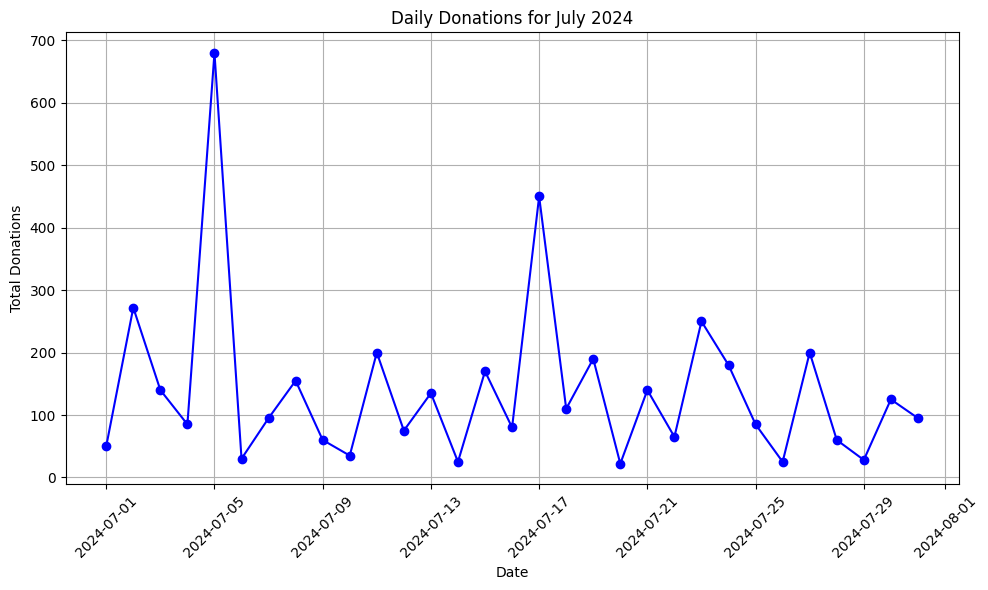

In [139]:
july = """
SELECT Date, SUM(Amount) AS Total_Donations
FROM church
WHERE strftime('%Y-%m', Date) = '2024-07'
GROUP BY Date
ORDER BY Date;
"""
june_donations = pd.read_sql_query(july, conn)

# Convert 'Date' column to datetime
june_donations['Date'] = pd.to_datetime(june_donations['Date'])

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(june_donations['Date'], june_donations['Total_Donations'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Daily Donations for July 2024')
plt.xlabel('Date')
plt.ylabel('Total Donations')
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Lets find out who and what type they gave the most

In [140]:
%%sql
SELECT 
    Type,
    Name,
    Amount
FROM 
    church
WHERE 
    strftime('%Y-%m', Date) = '2024-07'
ORDER BY 
    Amount DESC
LIMIT 3

 * sqlite:///Church.db
Done.


Type,Name,Amount
Local_Church_Budget,LIAM WILLIAMS,500
Local_Church_Building,JACKSON SANDERS,450
Local_Church_Budget,MASON FOSTER,250


People seem to be more generous when it comes to summer time, beccause it's not the tithe but the offerings that goes up. Would it be the weather, the holydays? Something to make an study

While we see an steadfast amount in Tithes donations throught the year

In [ ]:
# Closing database connection
conn.close()